---
title: California Housing Valuation - A Geo-XAI Approach
date: 2025-12-25
summary: Integrating GIS Feature Engineering with Explainable AI.
---


# California Housing Valuation: A Geo-XAI Approach
### Integrating GIS Feature Engineering with Explainable AI

#### 1. Project Overview
This project aims to build a robust valuation model for California real estate by fusing **Geospatial Analysis** with **Machine Learning**. Unlike traditional models that treat location merely as coordinates, this approach engineers spatial features (specifically proximity to the coastline) to capture the non-linear economic value of "location".

#### 2. Key Objectives
* **Quantify the "Location Premium":** Determine exactly how much value proximity to the ocean adds to a property.
* **Enhance Model Performance:** Utilise **XGBoost** to capture complex, non-linear relationships in housing data.
* **Ensure Explainability:** Deploy **SHAP (SHapley Additive exPlanations)** to deconstruct the "black box" model and visualise the marginal contribution of spatial features.

#### 3. Methodological Highlights
* **GIS Engineering:** Topology repair (`buffer(0)`) and metric projection (EPSG:3310) for accurate distance calculations.
* **Explainable AI:** Global and local interpretation using Game Theory concepts (Shapley values).

## 1 Data Acquisition and Setup

**Objective:**
To extract the raw California Housing dataset and initialise the analytical environment.

**Methodology:**
Utilised `pandas` for data manipulation. The dataset is sourced directly from the repository, ensuring reproducibility. This stage involves a preliminary inspection of the data structure to identify potential quality issues (e.g., missing values or data types).

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shap
import xgboost as xgb
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.model_selection import train_test_split

# --- Step 1: Load Dataset ---
# URL for the California Housing dataset
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
print("Status: Downloading dataset...")
df = pd.read_csv(url)

print(f"Success: Dataset loaded with {len(df)} records.")
# Display first 5 rows
df.head()

Status: Downloading dataset...
Success: Dataset loaded with 20640 records.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 2 Geospatial Feature Engineering (GIS)

**The Problem:**
Raw GPS coordinates (Latitude/Longitude) are insufficient for Machine Learning models to intuitively understand "proximity". A model does not inherently know that a specific coordinate is "near the beach".

**The Solution:**
Engineered a new feature: **`dist_to_coast_km`**.

**Technical Implementation:**
1.  **Coordinate Transformation:** Converted the dataset from a global angular system (EPSG:4326, WGS84) to a local projected system (EPSG:3310, California Albers). This allows us to measure distances in **metres** rather than degrees, which is crucial for accuracy.
2.  **Topology Repair:** Real-world geospatial data often contains geometry errors (e.g., self-intersections). We applied a **`buffer(0)`** operation to mathematically repair the coastline polygon, ensuring robust spatial operations.
3.  **Spatial Join & Calculation:** We calculated the geodesic distance from every property to the nearest point on the California coastline.

In [9]:
# GIS Feature Engineering
# Calculate the precise geodesic distance from each property to the nearest coastline.

# Convert DataFrame to GeoDataFrame
# Initial CRS: EPSG:4326 (WGS84 - Latitude/Longitude)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

print("Fetching California coastline data...")
# Load California counties boundary from public GeoJSON
ca_url = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson"
ca_counties = gpd.read_file(ca_url)

# Topology Repair
print("Repairing topology errors (Buffer 0 fix)...")
# Fix self-intersection or invalid geometries to prevent dissolve errors
ca_counties['geometry'] = ca_counties.geometry.buffer(0)

# Dissolve counties to get the outer boundary of California
print("Dissolving boundaries...")
ca_boundary = ca_counties.dissolve()

# Reproject to EPSG:3310 (California Albers) for accurate meter-based distance calculation
print("Reprojecting to EPSG:3310 (Meters)...")
gdf = gdf.to_crs("EPSG:3310")
ca_boundary = ca_boundary.to_crs("EPSG:3310")

# Extract the boundary line
coastline = ca_boundary.boundary

print("Calculating distance to coast")
# Calculate distance for every point
gdf['dist_to_coast'] = gdf.geometry.apply(lambda x: coastline.distance(x))

# Convert back to standard DataFrame for Machine Learning
df_ml = pd.DataFrame(gdf.drop(columns='geometry'))
# Convert meters to kilometers for better readability
df_ml['dist_to_coast_km'] = df_ml['dist_to_coast'] / 1000 

print("GIS Feature Engineering complete.")
print(df_ml[['longitude', 'latitude', 'median_house_value', 'dist_to_coast_km']].head())

Fetching California coastline data...


d:\python\envs\spatial_env\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
d:\python\envs\spatial_env\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


Repairing topology errors (Buffer 0 fix)...
Dissolving boundaries...
Reprojecting to EPSG:3310 (Meters)...
Calculating distance to coast
GIS Feature Engineering complete.
   longitude  latitude  median_house_value  dist_to_coast_km
0    -122.23     37.88            452600.0          6.721602
1    -122.22     37.86            358500.0          7.159210
2    -122.24     37.85            352100.0          5.249944
3    -122.25     37.85            341300.0          4.381984
4    -122.25     37.85            342200.0          4.381984


## 3 Predictive Modelling with XGBoost

**Objective:**
To train a high-performance regression model capable of predicting median house values.

**Methodology:**
We employed **XGBoost (eXtreme Gradient Boosting)**.

**Why XGBoost?**
Real estate pricing is rarely linear. The relationship between income, location, and price is complex and multifaceted. Tree-based ensemble methods like XGBoost excel at capturing these **non-linear dependencies** and interactions between features (e.g., the interaction between high income and coastal location) better than traditional Linear Regression.

In [7]:
# Data Preparation & Modeling 

# Feature Selection:
# Remove target variable, old categorical column, and the raw meter-distance column
X = df_ml.drop(columns=['median_house_value', 'ocean_proximity', 'dist_to_coast'])

# Handle missing values (Simple imputation with mean)
X = X.fillna(X.mean())

y = df_ml['median_house_value']

# Split data into Training and Testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise and Train XGBoost Regressor
print("Training XGBoost Model...")
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Evaluate Model
score = model.score(X_test, y_test)
print(f"Success: Model R² Score: {score:.4f}")

Training XGBoost Model...
Success: Model R² Score: 0.8187


## 4 Model Explainability (XAI)

**The Problem:**
While XGBoost offers high accuracy, it is often criticised as a "black box"—it is difficult to understand *why* it makes a specific prediction. In a commercial setting, stakeholders need to trust the logic behind the valuation.

**The Solution:**
We utilised **SHAP (SHapley Additive exPlanations)** values.

**Significance:**
SHAP values originate from Game Theory. They mathematically allocate the credit (or blame) for a specific price prediction among the various features.
* **Global Interpretability:** The Summary Plot (below) shows us which features are the most important drivers of price across the entire state.
* **Directionality:** We can observe whether a feature (like `dist_to_coast_km`) is driving prices **up** (positive SHAP) or **down** (negative SHAP).

Status: Calculating SHAP values...
Displaying SHAP Summary Plot:


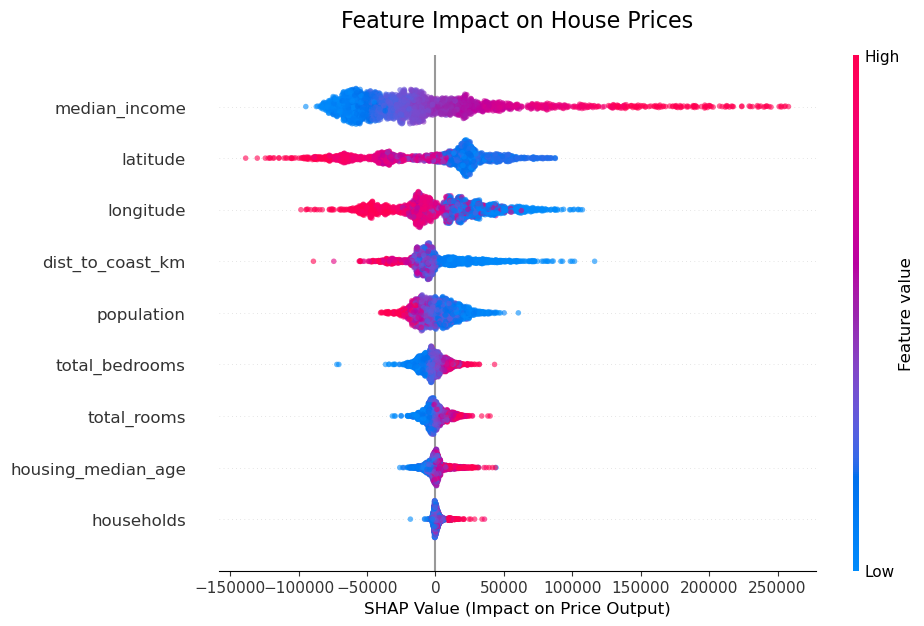

In [ ]:
# Model Explainability (SHAP Analysis)

print("Status: Calculating SHAP values...")

# Initialise TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualisation: Optimized Beeswarm Plot
# Downsampling to avoid overplotting and improve clarity
limit = 2000
if X_test.shape[0] > limit:
    indices = np.random.choice(X_test.shape[0], limit, replace=False)
    shap_subset = shap_values[indices]
    X_subset = X_test.iloc[indices]
else:
    shap_subset = shap_values
    X_subset = X_test

# Plotting
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_subset, X_subset, 
                  max_display=10, 
                  alpha=0.6, 
                  plot_size=(10, 6),
                  show=False)

# Add Labels
plt.title("Feature Impact on House Prices", fontsize=16, pad=20)
plt.xlabel("SHAP Value (Impact on Price Output)", fontsize=12)
plt.yticks(fontsize=12)

print("Displaying SHAP Summary Plot:")
plt.show()

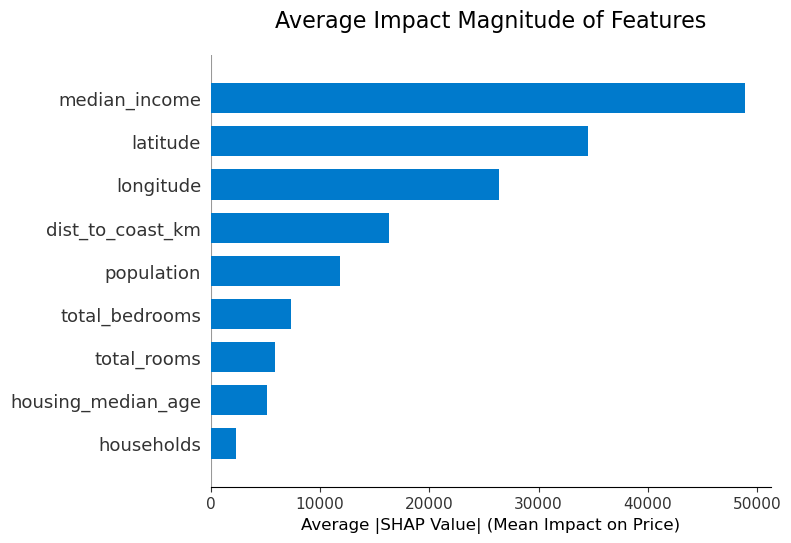

In [5]:
plt.figure(figsize=(10, 6))

shap.summary_plot(shap_values, X_test, 
                  plot_type="bar", 
                  max_display=10, 
                  color='#007acc', 
                  show=False)

plt.title("Average Impact Magnitude of Features", fontsize=16, pad=20)
plt.xlabel("Average |SHAP Value| (Mean Impact on Price)", fontsize=12)
plt.show()

## 5 Interactive Visualisation of Location Premium

**Objective:**
To visualise the **spatial heterogeneity** of housing value drivers.

**The Solution:**
Generated an interactive HeatMap that visualises the **Location Premium**.

**How to Read this Map:**
Instead of mapping the *total house price*, we map the **SHAP Interaction Values** of the spatial features.
* **Red Areas:** Indicate a **positive location premium**. The geography itself adds significant value to the property (e.g., Coastal zones, Bay Area).
* **Blue Areas:** Indicate a **negative location impact**. The location detracts from the potential value compared to the state average (e.g., Inland deserts).

**Technical Note:**
To enable web-based rendering via `Folium`, we perform explicit type conversion (`float32` to `float`) to ensure JSON serialisation compatibility.

In [ ]:
# Interactive Geospatial Visualization
# Visualise the "Location Premium" (Pure spatial contribution to price)

print("Generating interactive map with legend...")

# 1. Sampling for performance
sample_size = 2000 
actual_size = min(sample_size, len(X_test))
indices = np.random.choice(X_test.index, size=actual_size, replace=False)

# 2. Extract Data
lat_idx = X_test.columns.get_loc('latitude')
lon_idx = X_test.columns.get_loc('longitude')
dist_idx = X_test.columns.get_loc('dist_to_coast_km')

subset_shap = shap_values[np.isin(X_test.index, indices)]

# Calculate Location Premium: Sum of Latitude, Longitude, and Distance-to-Coast effects
location_impact = subset_shap[:, lat_idx] + subset_shap[:, lon_idx] + subset_shap[:, dist_idx]

# Define range for the legend
min_val = np.min(location_impact)
max_val = np.max(location_impact)

# Prepare coordinates
lat_data = X_test.loc[indices, 'latitude'].values
lon_data = X_test.loc[indices, 'longitude'].values

# 3. Create Base Map
m = folium.Map(location=[36.7, -119.4], zoom_start=6, tiles='CartoDB dark_matter')

# 4. Add Color Legend (Red = High Premium, Blue = Negative Impact)
colormap = cm.LinearColormap(
    colors=['blue', 'cyan', 'lime', 'yellow', 'red'],
    vmin=min_val,
    vmax=max_val,
    caption='Location Premium (Net Impact on Price in USD)' 
)
m.add_child(colormap)

# 5. Prepare Data for HeatMap 
data_heat = []
for i in range(len(lat_data)):
    # Explicitly convert numpy types to standard python floats
    lat = float(lat_data[i])
    lon = float(lon_data[i])
    weight = float(location_impact[i])
    
    # Normalize weight to 0-1 range for the heatmap gradient
    normalized_weight = (weight - min_val) / (max_val - min_val)
    
    data_heat.append([lat, lon, normalized_weight])

# 6. Add HeatMap Layer
HeatMap(data_heat, radius=15, blur=20, 
        gradient={0.0: 'blue', 0.25: 'cyan', 0.5: 'lime', 0.75: 'yellow', 1.0: 'red'}).add_to(m)

print(f"Map generated. Value range: ${min_val:.0f} to ${max_val:.0f}")
m

Generating interactive map with legend...
Map generated. Value range: $-117689 to $205764
